In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import utils

In [5]:
df = utils.sim_happiness()
df2 = df[df.age > 17].copy()
df2['A'] = (df2.age - 18) / (65 - 18)

# H -> M <- A
# A -> H

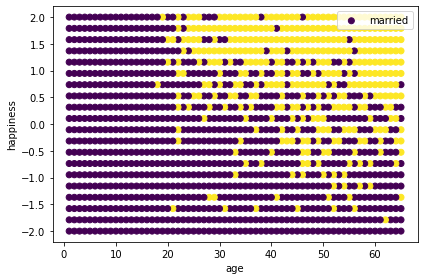

In [6]:
plt.scatter(df.age, df.happiness, c=df.married, label="married")
plt.xlabel("age")
plt.ylabel("happiness")
plt.legend()
plt.tight_layout()

In [7]:
mid = df2.loc[:, "married"].astype(int).values

with pm.Model() as m69:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)

    mu = a[mid] + bA * df2.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu=mu, sigma=sigma, observed=df2.happiness.values)
    samples = pm.sample(1000)
    ppc = pm.sample_posterior_predictive(samples)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [8]:
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.269,0.064,-0.384,-0.149,0.001,0.001,1959.0,2332.0,1.0
a[1],1.237,0.084,1.076,1.387,0.002,0.001,1890.0,2074.0,1.0
bA,-0.612,0.110,-0.823,-0.409,0.003,0.002,1681.0,1884.0,1.0
sigma,0.987,0.022,0.947,1.031,0.000,0.000,2726.0,2478.0,1.0


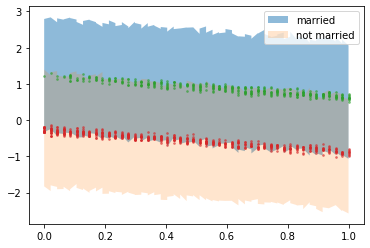

In [9]:
happiness_hpd = pm.stats.hdi(ppc.posterior_predictive["happiness"], hdi_prob=0.89).to_array().values[0]
# idx = np.argsort(df2.happiness.values)
idx = np.arange(len(df2))
d2_A_order = df2.A.values[idx]
happiness_hpd = happiness_hpd[idx]
married = mid[idx] == 1

plt.fill_between(df2.A.values[married],
    happiness_hpd[:, 0][married], happiness_hpd[:, 1][married], alpha=0.5, label="married")
plt.fill_between(df2.A.values[~married],
    happiness_hpd[:, 0][~married], happiness_hpd[:, 1][~married], alpha=0.2, label="not married")

plt.scatter(df2.A.values[married], happiness_hpd[married].mean(axis=1), alpha=0.5, s=3)
plt.scatter(df2.A.values[~married], happiness_hpd[~married].mean(axis=1), alpha=0.5, s=3)

plt.legend()

In [10]:
mid = df2.loc[:, "married"].astype(int).values

with pm.Model() as m610:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)

    mu = a + bA * df2.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu=mu, sigma=sigma, observed=df2.happiness.values)
    samples2 = pm.sample(1000)
    ppc2 = pm.sample_posterior_predictive(samples2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [11]:
az.summary(samples2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.077,-0.144,0.147,0.002,0.001,1940.0,2170.0,1.0
bA,0.002,0.131,-0.245,0.250,0.003,0.002,1867.0,2127.0,1.0
sigma,1.216,0.028,1.164,1.271,0.001,0.000,2594.0,2428.0,1.0


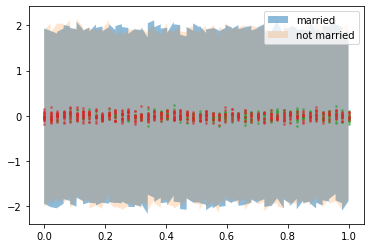

In [12]:
happiness_hpd = pm.stats.hdi(ppc2.posterior_predictive["happiness"], hdi_prob=0.89).to_array().values[0]
# idx = np.argsort(df2.happiness.values)
idx = np.arange(len(df2))
d2_A_order = df2.A.values[idx]
happiness_hpd = happiness_hpd[idx]
married = mid[idx] == 1

plt.fill_between(df2.A.values[married],
    happiness_hpd[:, 0][married], happiness_hpd[:, 1][married], alpha=0.5, label="married")
plt.fill_between(df2.A.values[~married],
    happiness_hpd[:, 0][~married], happiness_hpd[:, 1][~married], alpha=0.2, label="not married")

plt.scatter(df2.A.values[married], happiness_hpd[married].mean(axis=1), alpha=0.5, s=3)
plt.scatter(df2.A.values[~married], happiness_hpd[~married].mean(axis=1), alpha=0.5, s=3)

plt.legend()

In [72]:
a = samples.posterior["a"].values[0].mean(axis=0)
bA = samples.posterior["bA"].values[0].mean(axis=0)
error = df2.happiness - (a[mid] + bA * df2.A.values)
(error**2).mean()

0.9692202865323993

In [73]:
a = samples2.posterior["a"].values[0].mean(axis=0)
bA = samples2.posterior["bA"].values[0].mean(axis=0)
error = df2.happiness - (a + bA * df2.A.values)
(error**2).mean()

1.4736888129273127

In [88]:
az.compare({"m69": samples, "m610": samples2}, ic="WAIC")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m69,0,-1351.000609,3.653878,0.000000,0.972633,18.952928,0.000000,False,log
m610,1,-1551.007656,2.383428,200.007047,0.027367,13.805544,18.221112,False,log
